# paddleOCR — Evaluation & Debug Notebook  
**Author:** Manel

## Purpose
Evaluate paddleOCR on document pages (PDF → images) with:
- Visual inspection (original + preprocessed)
- OCR text preview
- Word-level bounding boxes and confidence
- Quick sweeps over preprocessing + `psm` layouts


#### Imports

In [ ]:
import os
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from paddleocr import PaddleOCR
import cv2
from IPython.display import display
import pandas as pd
from pytesseract import Output
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

#### Paths

In [ ]:
BASE_DIR = Path.cwd()  # ...\DocumentAgent\Notebooks
DATA_DIR = BASE_DIR.parent / "data" / "images"

#### Display Helpers

In [ ]:
def show(img, title=None, figsize=(10, 12)):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    plt.figure(figsize=figsize)
    cmap = "gray" if img.mode in ["L", "1"] else None
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def crop(img, x1, y1, x2, y2):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    return img.crop((x1, y1, x2, y2))

In [ ]:
# Example usage
DEFAULT_IMAGE = DATA_DIR / "page_2.png"
show(DEFAULT_IMAGE, "Original")
show(crop(DEFAULT_IMAGE, 200, 200, 2400, 900), "Zoomed region")

#### Set paddleOCR

In [ ]:
ocr = PaddleOCR(lang='en')

In [ ]:
DEFAULT_IMAGE

In [ ]:
result = ocr.predict('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png')

In [ ]:
page = result[0]
texts = page['rec_texts'] # recognized text strings
scores = page['rec_scores'] # confidence scores for each text line
boxes  = page['rec_polys'] #  bounding box coordinates

for text, score, box in zip(texts, scores, boxes):
    # box is a numpy array like [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    coords = box.astype(int).tolist()  # convert to normal list of ints
    print(f"{text:25} | {score:.3f} | {coords}")

In [ ]:
img = page['doc_preprocessor_res']['output_img']

### Extracted lines & bounding boxes (processed image)

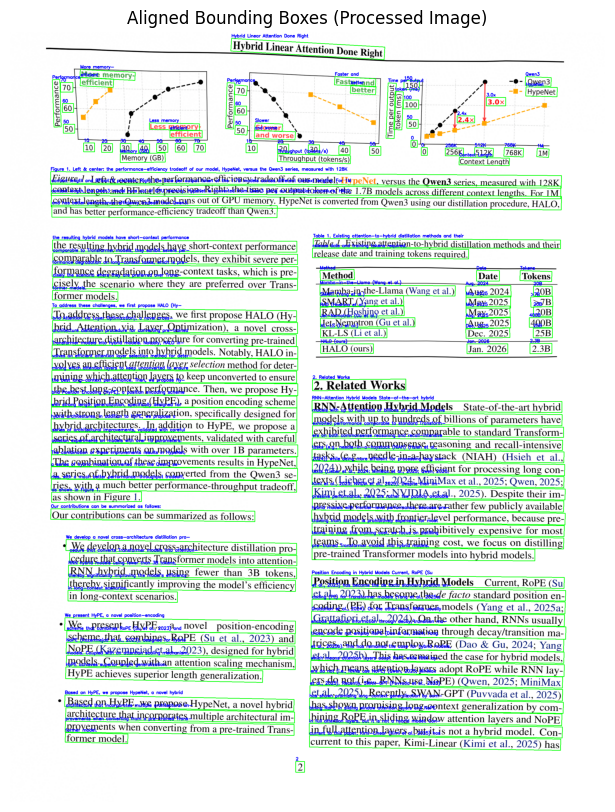

In [14]:
img_plot = img.copy()

for text, box in zip(texts, boxes):
    pts = np.array(box, dtype=int)
    cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
    x, y = pts[0]
    cv2.putText(img_plot, text, (x, y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligned Bounding Boxes (Processed Image)")
plt.show()

text                                          |   conf | box
---------------------------------------------------------------------------------------
256K                                          |  1.000 | [[1865, 497], [1943, 497], [1943, 530], [1865, 530]]
150                                           |  1.000 | [[1688, 208], [1754, 208], [1754, 246], [1688, 246]]
512K                                          |  1.000 | [[1991, 495], [2071, 498], [2070, 534], [1990, 531]]
100                                           |  1.000 | [[1685, 291], [1751, 291], [1751, 329], [1685, 329]]
70                                            |  1.000 | [[788, 477], [837, 477], [837, 514], [788, 514]]
HypeNet                                       |  1.000 | [[2211, 235], [2345, 237], [2344, 277], [2210, 274]]
Method                                        |  1.000 | [[1328, 1021], [1474, 1017], [1476, 1060], [1330, 1064]]
768K                                          |  1.000 | [[2118, 495], [2200, 498

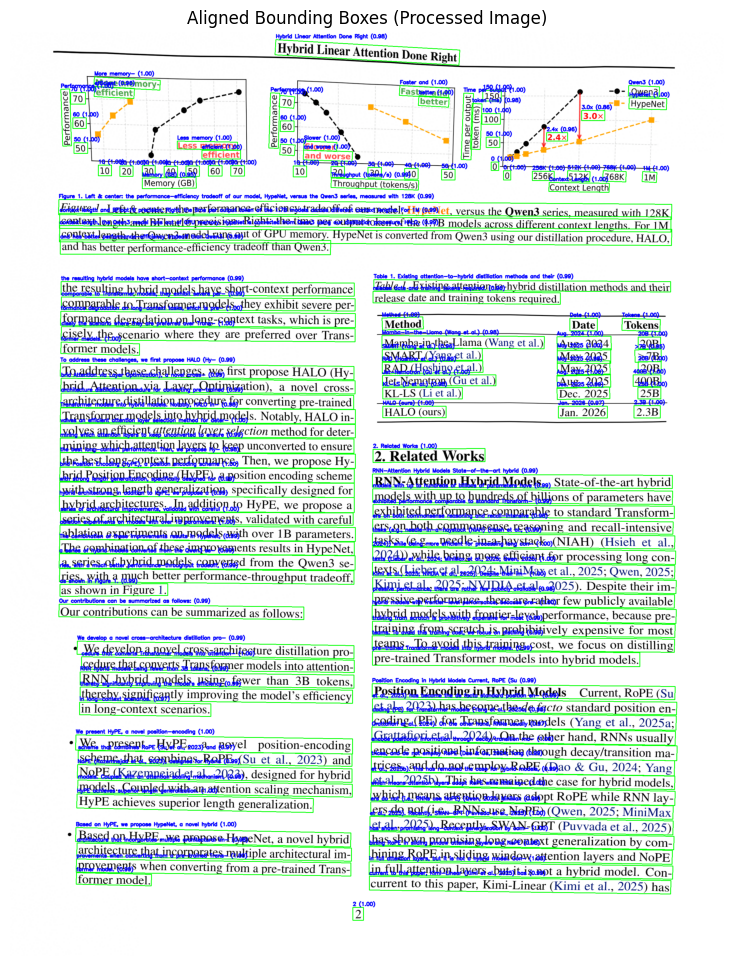

In [ ]:
def extract_page_fields(result, page_idx=0):
    """Extract PaddleOCR page fields with basic validation."""
    if not result or page_idx >= len(result):
        raise ValueError(f"`result` is empty or page_idx={page_idx} out of range.")

    page = result[page_idx]
    required = ["rec_texts", "rec_scores", "rec_polys"]
    missing = [k for k in required if k not in page]
    if missing:
        raise KeyError(f"Missing keys in page dict: {missing}")

    texts  = page["rec_texts"]
    scores = page["rec_scores"]
    boxes  = page["rec_polys"]

    if not (len(texts) == len(scores) == len(boxes)):
        raise ValueError(
            f"Length mismatch: texts={len(texts)}, scores={len(scores)}, boxes={len(boxes)}"
        )

    # Image (optional)
    img = None
    try:
        img = page["doc_preprocessor_res"]["output_img"]
    except Exception:
        pass

    return page, texts, scores, boxes, img


def print_ocr_lines(texts, scores, boxes, min_score=0.0, top_k=None, text_width=40):
    """Pretty-print OCR results as a table-like output."""
    rows = []
    for t, s, b in zip(texts, scores, boxes):
        if s < min_score:
            continue
        coords = np.asarray(b).astype(int).tolist()
        rows.append((t, float(s), coords))

    # Sort by confidence (descending) if you want a "study" feel
    rows.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        rows = rows[:top_k]

    # Header
    print(f"{'text':{text_width}} | {'conf':>6} | box")
    print("-" * (text_width + 3 + 6 + 3 + 30))

    # Rows
    for t, s, coords in rows:
        t_fmt = (t[: text_width - 1] + "…") if len(t) > text_width else t
        print(f"{t_fmt:{text_width}} | {s:6.3f} | {coords}")


def draw_ocr_boxes(img, texts, boxes, scores=None, min_score=0.0,
                   box_thickness=2, font_scale=0.6):
    """
    Draw polygons + labels on a copy of img.
    If scores is given, filters by min_score.
    """
    if img is None:
        raise ValueError("No image available to draw on (img is None).")

    img_plot = img.copy()

    for i, (t, b) in enumerate(zip(texts, boxes)):
        s = scores[i] if scores is not None else 1.0
        if s < min_score:
            continue

        pts = np.asarray(b, dtype=int)

        # Draw polygon
        cv2.polylines(img_plot, [pts], isClosed=True, color=(0, 255, 0), thickness=box_thickness)

        # Put label near top-left-ish point
        x, y = int(pts[0][0]), int(pts[0][1])
        label = f"{t}"
        if scores is not None:
            label = f"{t} ({s:.2f})"

        cv2.putText(
            img_plot, label,
            (x, max(0, y - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale, (255, 0, 0), 2, cv2.LINE_AA
        )

    return img_plot


def show_image(img, title=None, figsize=(10, 12)):
    """Show image with best-effort color handling (BGR->RGB if needed)."""
    # Heuristic: if it looks like a typical OpenCV BGR image, convert
    img_show = img
    if img.ndim == 3 and img.shape[2] == 3:
        # assume BGR (most common from cv2 / Paddle doc preprocessor)
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(img_show)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

### Execution 1

text                                          |   conf | box
---------------------------------------------------------------------------------------
256K                                          |  1.000 | [[1865, 497], [1943, 497], [1943, 530], [1865, 530]]
150                                           |  1.000 | [[1688, 208], [1754, 208], [1754, 246], [1688, 246]]
512K                                          |  1.000 | [[1991, 495], [2071, 498], [2070, 534], [1990, 531]]
100                                           |  1.000 | [[1685, 291], [1751, 291], [1751, 329], [1685, 329]]
70                                            |  1.000 | [[788, 477], [837, 477], [837, 514], [788, 514]]
HypeNet                                       |  1.000 | [[2211, 235], [2345, 237], [2344, 277], [2210, 274]]
Method                                        |  1.000 | [[1328, 1021], [1474, 1017], [1476, 1060], [1330, 1064]]
768K                                          |  1.000 | [[2118, 495], [2200, 498

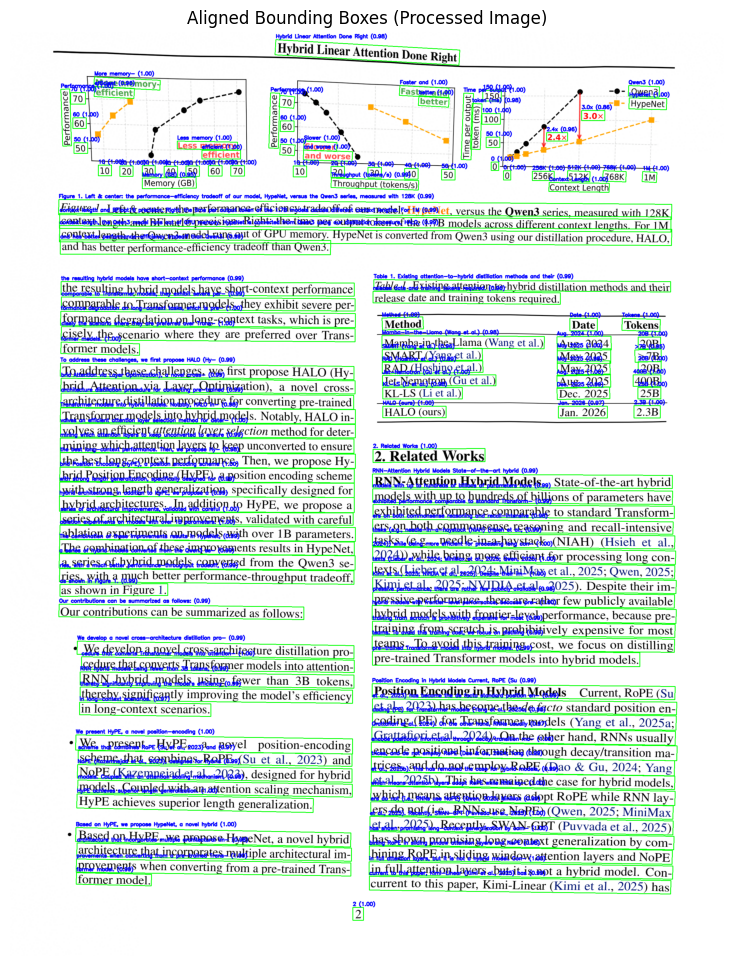

In [16]:
page, texts, scores, boxes, img = extract_page_fields(result, page_idx=0)

print_ocr_lines(texts, scores, boxes, min_score=0.50, top_k=50, text_width=45)

if img is not None:
    img_annot = draw_ocr_boxes(img, texts, boxes, scores=scores, min_score=0.50)
    show_image(img_annot, title="Aligned Bounding Boxes (Processed Image)")
else:
    print("No preprocessed image found at page['doc_preprocessor_res']['output_img'].")